In [ ]:
!pip install atomicds

In [76]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from atomicds.client import Client
from atomicds.results import RHEEDImageCollection

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

work_dir = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 1 seconds


In [29]:
# To get an API key to run this example, email chris@atomicdatasciences.com
api_key = "YOUR_API_KEY_HERE"

api = Client(api_key=api_key, endpoint="https://api.atomicdatasciences.com")
result = api.search("WSe2", include_organization_data=False)
result = result.sort_values("File Name").reset_index(drop=True)

Obtaining data results: 100%|██████████| 76/76 [00:17<00:00,  4.41it/s]


In [31]:
# define annotation function to simplify adding labels to the dataset

def parse_extra_data(df):
    extra_data = []
    for vi, row in df.iterrows():
        
        if "0.2deg" in row["Sample Notes"]:
            miscut = 0.2
        elif "0.5deg" in row["Physical Sample Name"]:
            miscut = 0.5
        else:
            miscut = "none"

        extra_data.append({
                    "name": row["Physical Sample Name"],
                    "quality": "textured" if "Quality: Textured" in row["Sample Notes"] else "good",
                    "run_date": pd.to_datetime(row["Physical Sample Name"].split("-")[0]),
                    "doping": "V" if "-V-" in row["Physical Sample Name"] else "N2" if "-N2-" in row["Physical Sample Name"] else "none",
                    "miscut": miscut
                  }
        )
    return extra_data

In [32]:
# filter the data for one angle of patterns and fetch the results.
image_after_growth = result.loc[result["File Name"].str.contains("after")].loc[result["File Name"].str.contains("angle1")].reset_index(drop=True)
after_growth_dataset = api.get(image_after_growth["Data ID"].to_list())

# Build an image collection dataset with labels
after_growth_dataset = RHEEDImageCollection(after_growth_dataset, extra_data=parse_extra_data(image_after_growth), sort_key="run_date")

Obtaining data results: 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]


In [34]:
# Align the patterns in the dataset to maximize shared feature labels across samples
aligned_after_growth_dataset = after_growth_dataset.align_fingerprints(search_range=0.2)

In [92]:
def folded_logistic_regression_with_bagging(X, y, data_size=None, n_folds=128):

    all_acc_list = []
    wrong_idxs = []
    right_idxs = []
    cm_total = np.zeros((2,2))
    probability_df = pd.DataFrame(np.zeros((len(X), 5)), columns=["index", "good", "textured", "counts", "true_label"])
    for model_fold in range(n_folds):

        coefs = []
        intercepts = []
        n_trials = 100

        pre_CV_test_split = np.random.choice(len(X), size=1, replace=False)
        

        remaining_idx = [i for i in range(len(X)) if i not in pre_CV_test_split]
        np.random.shuffle(remaining_idx)

        if data_size is not None:
            remaining_idx = remaining_idx[:data_size]
        
        completed_trials = 0
        while completed_trials < n_trials:

            train_idx = np.random.choice(remaining_idx, size=len(remaining_idx), replace=True)

            X_train = X.iloc[train_idx]
            y_train = y.iloc[train_idx]

            if len(pd.unique(y_train)) != 2:
                continue

            classifier = LogisticRegression(max_iter=200)
            classifier.fit(X_train, y_train)

            coefs.append(classifier.coef_)
            intercepts.append(classifier.intercept_)

            completed_trials += 1

        # print(completed_trials)
        avg_coef = np.mean(coefs, axis=0)
        avg_intercept = np.mean(intercepts, axis=0)

        final_model = LogisticRegression(max_iter=200)
        final_model.coef_ = avg_coef
        final_model.intercept_ = avg_intercept
        final_model.classes_ = np.unique(y)
        # final_model.feature_names_in_ = X.columns

        # print(final_model.classes_)
        X_test = X.iloc[pre_CV_test_split].copy()
        probs = final_model.predict_proba(X_test)

        probability_df.iloc[pre_CV_test_split, 0] = pre_CV_test_split
        probability_df.iloc[pre_CV_test_split, 1:3] += probs
        probability_df.iloc[pre_CV_test_split, 3] += 1
        probability_df.iloc[pre_CV_test_split, 4] = y.iloc[pre_CV_test_split]
        # probability_df.iloc[pre_CV_test_split, 5] 

        all_pred = final_model.predict(X_test)
        really_all_pred = final_model.predict(X)

        all_acc = accuracy_score(y.iloc[pre_CV_test_split], all_pred)
        really_all_acc = accuracy_score(y, really_all_pred)
        
        wrong_idx = pre_CV_test_split[np.where(y.iloc[pre_CV_test_split] != all_pred)[0]]
        wrong_idxs.extend(wrong_idx)
        
        right_idx = pre_CV_test_split[np.where(y.iloc[pre_CV_test_split] == all_pred)[0]]
        right_idxs.extend(right_idx)

        cm = confusion_matrix(y.iloc[pre_CV_test_split], all_pred, labels=["good", "textured"])
        cm_total += cm

        all_acc_list.append(all_acc)

    print(f"Mean All Accuracy: {np.mean(all_acc_list)}")
    print(f"Global accuracy: {really_all_acc}")

    probability_df["good"] = probability_df["good"] / probability_df["counts"]
    probability_df["textured"] = probability_df["textured"] / probability_df["counts"]

    # print(probability_df)

    return probability_df, cm_total, all_acc_list, wrong_idxs, right_idxs, final_model

## WSE2 FILMS

In [93]:
## Classifying WSe2 patterns based on the provided grain alignment labels

aligned_after_growth_df = aligned_after_growth_dataset.get_pattern_dataframe(symmetrize=False, streamline=False, normalize=True, return_as_features=True)
aligned_after_growth_df = aligned_after_growth_df.fillna(0)

label_columns = ['quality', 'run_date', 'doping', 'name']

aligned_after_growth_df_for_fitting = aligned_after_growth_df.drop(columns=label_columns).select_dtypes(include='number')

X = aligned_after_growth_df_for_fitting
y = aligned_after_growth_df['quality']

probability_df, cm_total, all_acc_list, wrong_idxs, right_idxs, final_model = folded_logistic_regression_with_bagging(X, y, n_folds=256)


/var/folders/27/gm005n0s177b05wywv0yp18m0000gn/T/ipykernel_2902/1124028853.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  aligned_after_growth_df_for_fitting = aligned_after_growth_df.drop(columns=label_columns).select_dtypes(include='number')
/var/folders/27/gm005n0s177b05wywv0yp18m0000gn/T/ipykernel_2902/2135411619.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['good']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  probability_df.iloc[pre_CV_test_split, 4] = y.iloc[pre_CV_test_split]


     quality   run_date doping                         name
                                                           
0   textured 2021-10-28     N2      28Oct2021-N2-WSe2-Run43
1   textured 2021-10-30     N2      30Oct2021-N2-WSe2-Run45
2   textured 2021-10-31     N2      31Oct2021-N2-WSe2-Run46
3   textured 2021-11-02     N2      02Nov2021-N2-WSe2-Run47
4       good 2023-01-20      V   20January2023-V-WSe2-Run40
5       good 2023-02-13      V  13February2023-V-WSe2-Run46
6       good 2023-02-16      V  16February2023-V-WSe2-Run47
7       good 2023-03-23      V     23March2023-V-WSe2-Run57
8       good 2023-03-30      V     30March2023-V-WSe2-Run59
9   textured 2024-02-07   none          07Feb2024-WSe2-Run1
10  textured 2024-02-08   none          08Feb2024-WSe2-Run2
11      good 2024-03-20   none        20March2024-WSe2-Run9
12      good 2024-03-24   none       24March2024-WSe2-Run11
13      good 2024-03-26   none       26March2024-WSe2-Run12
Mean All Accuracy: 0.8166666666666667
Gl

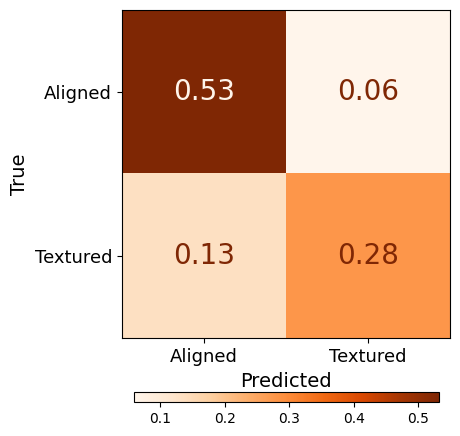

In [79]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total / cm_total.sum(), display_labels=["Aligned", "Textured"])
fig, ax = plt.subplots()
fig.set_tight_layout(True)
disp.plot(ax=ax, cmap=plt.cm.Oranges, colorbar=False, text_kw={'size': 20}, values_format=".2f")
plt.gcf().colorbar(disp.im_, orientation='horizontal', ax=ax, pad=0.12, aspect=30, shrink=0.5)
plt.ylabel('True', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.show()


[6, 9, 6, 9, 9, 10, 10, 6, 10, 9, 6, 10, 10, 6, 6, 6, 9, 9, 9, 10, 9, 10, 9, 6, 9, 6, 6, 6, 9, 10, 9, 10, 9, 9, 6, 10, 9, 10, 10, 10, 6, 9, 10, 10, 10, 6, 6, 10, 10]
[ 6  9 10]
[ 0.  0.  0.  0.  0.  0. 15.  0.  0. 16. 18.  0.  0.  0.]
[20. 17. 15. 19. 20. 20.  4. 17. 21.  0.  0. 12. 18. 24.]
[20. 17. 15. 19. 20. 20. 19. 17. 21. 16. 18. 12. 18. 24.]


/var/folders/27/gm005n0s177b05wywv0yp18m0000gn/T/ipykernel_2902/4125131581.py:3: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(pd.unique(wrong_idxs))


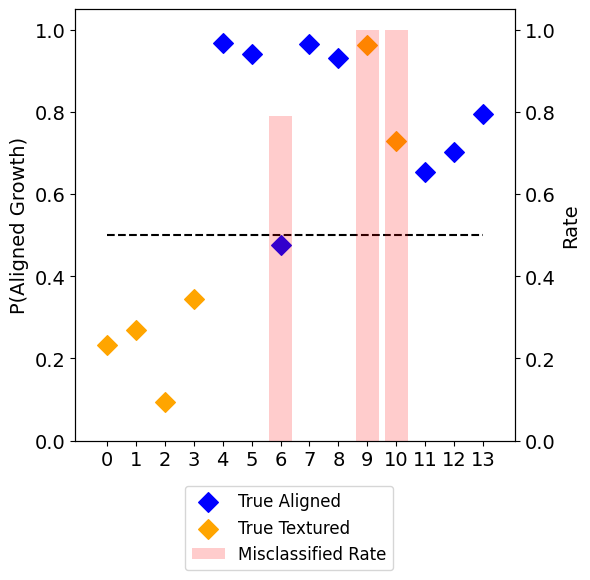

In [80]:
## look at which ones are wrong most frequently

fig2, ax = plt.subplots(1,1, figsize=(6, 6))
ax_right = ax.twinx()

sample_ids = np.arange(0, len(X), 1)
wrong_per_sample_frequency = np.zeros(len(X))
right_per_sample_frequency = np.zeros(len(X))
vals, counts = np.unique(wrong_idxs, return_counts=True)
wrong_per_sample_frequency[vals] += counts
right_vals, right_counts = np.unique(right_idxs, return_counts=True)
right_per_sample_frequency[right_vals] += right_counts
total_counts = wrong_per_sample_frequency + right_per_sample_frequency
bar = ax_right.bar(sample_ids, wrong_per_sample_frequency / total_counts, color='r', label='Misclassified Rate', alpha=0.2)

line_good = ax.scatter(probability_df.loc[probability_df["true_label"] == "good", "index"], probability_df.loc[probability_df["true_label"] == "good"][['good']].max(axis=1), marker='D', color='b', s=100, label="True Aligned")
line_textured = ax.scatter(probability_df.loc[probability_df["true_label"] == "textured", "index"], probability_df.loc[probability_df["true_label"] == "textured"][['good']].max(axis=1), marker='D', color='orange', s=100, label="True Textured")

lines = [line_good, line_textured, bar]
labels = [line.get_label() for line in lines]

ax.legend(lines, labels, fontsize=12, loc=(0.25, -0.3))
ax.set_ylim([0,1.05])
ax.hlines(0.5, 0, len(X)-1, color='k', linestyle='--')
ax.set_ylabel("P(Aligned Growth)", fontsize=14)
ax_right.set_ylabel("Rate", fontsize=14)
ax.set_xticks(np.arange(0, len(X), 1))
ax.tick_params(axis='both', labelsize=14)
ax_right.tick_params(axis='both', labelsize=14)
fig2.tight_layout()


In [82]:
## save figures, state, model

work_dir = "/Users/ccprice/Library/CloudStorage/OneDrive-AtomicDataSciences/AtomicDS/product/atom-cloud/case-studies/V-doping WSe2/paper/assets"

with open(work_dir+'/deposited_classification_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)